In [1]:
import os
import sys

import random
import glob
import cv2

from datetime import datetime

from pandas.core.common import flatten

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import torchvision.models as models

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ToTensor, Compose
from torchvision.datasets import ImageFolder

import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [3]:
classtolabel = {'fractured': 0, "not fractured": 1}

In [4]:
def time():
    
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    
    return(current_time)

def timestamp():
    
    return('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.now()))

In [5]:
os.chdir('/Users/anuragkotiyal/Desktop/Projects/Bone Fracture Detection/')

In [6]:
dataset_path = os.path.join(os.getcwd(), 'Dataset')
dataset_path

'/Users/anuragkotiyal/Desktop/Projects/Bone Fracture Detection/Dataset'

In [7]:
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')

In [8]:
train_dir

'/Users/anuragkotiyal/Desktop/Projects/Bone Fracture Detection/Dataset/train'

In [9]:
def show_image_samples(location = train_dir):
    
    labels = os.listdir(location)
    
    for label in labels:
        
        if label != '.DS_Store':
            
            print(f"Class: {label}")
            
            label_path = os.path.join(location, label)
            
            files = random.sample(os.listdir(label_path), 5)
            c, r = 5, 2
            
            figsize = (16, 8)
            plt.figure(figsize = figsize)
            
            for i, file in enumerate(files):
                
                plt.subplot(r, c, i+1)
                
                filepath = os.path.join(label_path, file)
                
                file = plt.imread(filepath)
                
                plt.imshow(file, aspect = None)
                plt.xticks([])
                plt.yticks([])
            
            plt.tight_layout()
            plt.show()

Class: fractured


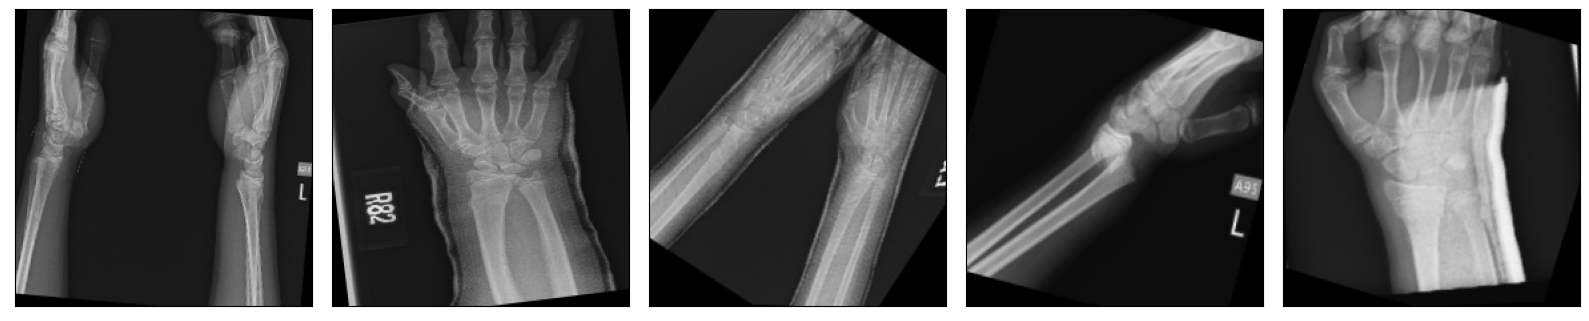

Class: not fractured


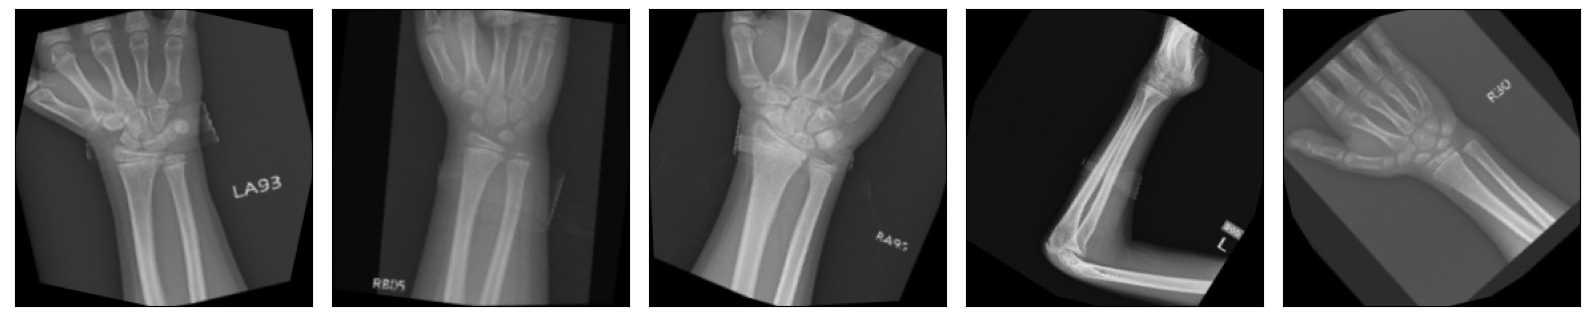

In [10]:
show_image_samples()

In [11]:
def create_files(filepath):
    
    image_path = []
    classes = []
    
    for data in glob.glob(filepath + '/*'):
        image_path.append(glob.glob(data + '/*'))
    
    image_path = list(flatten(image_path))
    
    for img in image_path:
        classes.append(img.split('/')[-2])
        
    return image_path

In [12]:
train_image_paths = create_files(train_dir)
val_image_paths = create_files(val_dir)
test_image_paths = create_files(test_dir)

In [13]:
train_image_paths[0]

'/Users/anuragkotiyal/Desktop/Projects/Bone Fracture Detection/Dataset/train/fractured/63.jpg'

In [14]:
class BoneFractureDataset(Dataset):
    
    def __init__(self, image_paths, transform = False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return(len(self.image_paths))
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        
        label = image_path.split('/')[-2]
        label = classtolabel[label]
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [15]:
transform = Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225] )
        ])

train_dataset = BoneFractureDataset(train_image_paths, transform)
val_dataset = BoneFractureDataset(val_image_paths, transform)
test_dataset = BoneFractureDataset(test_image_paths, transform)

In [16]:
def create_data(dataset, batch_size):
    return DataLoader(dataset, batchsize, shuffle = True)

In [17]:
batchsize = 16

train_data = create_data(train_dataset, batchsize)
val_data = create_data(val_dataset, batchsize)
test_data = create_data(test_dataset, batchsize)

In [18]:
next(iter(train_data))[0].shape

torch.Size([16, 3, 224, 224])

In [19]:
class CustomResnet(nn.Module):
    
    def __init__(self, num_classes, train_basemodel = False):
        super(CustomResnet, self).__init__()
        self.num_classes = num_classes
        self.train_basemodel = train_basemodel
        self.resnet = models.resnet50(weights = "IMAGENET1K_V1")
        self.classifier = nn.Sequential(nn.Linear(1000, 128),
                                        nn.ReLU(),
                                        nn.Dropout(0.5),
                                        nn.Linear(128, 2),
                                        nn.ReLU())
        
    def forward(self, x):
        x = self.resnet(x)
        x = self.classifier(x)
        
        if (self.train_basemodel):
            for name, param in self.resnet.named_parameters():
                param.requires_grad = True
        else:
            for name, param in self.resnet.named_parameters():
                param.requires_grad = False
            
        
        return x

In [20]:
def train_epoch():
    
    train_loss = 0.0
    correct = 0
    
    for i, batch in enumerate(train_data):
        
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
        avg_train_loss = train_loss/(i+1)
        
        correct += (predicted == labels).float().sum() 
        
    train_accuracy = 100 * correct / len(train_image_paths)
    
    return avg_train_loss, train_accuracy

In [21]:
def val_epoch():
    
    val_loss = 0.0
    correct = 0
    
    with torch.no_grad():
        
        for i , batch in enumerate(val_data):
            
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            loss = loss_fn(outputs, labels)
            
            val_loss += loss.item()
            correct += (predicted == labels).float().sum()
    
    avg_val_loss = val_loss/(i+1)
    val_accuracy = 100 * correct / len(val_image_paths)
    
    return avg_val_loss, val_accuracy

In [22]:
def test_epoch():
    
    test_loss = 0.0
    correct = 0
    
    with torch.no_grad():
        
        for i, batch in enumerate(test_data):
            
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            loss = loss_fn(outputs, labels)
            
            test_loss += loss.item()
            correct += (predicted == labels).float().sum()
    
    avg_test_loss = test_loss/(i+1)
    test_accuracy = 100 * correct / len(test_image_paths)
    
    return avg_test_loss, test_accuracy

In [23]:
model = CustomResnet(2).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = lr_scheduler.ExponentialLR(optimizer, gamma = 0.99)

In [24]:
%%time
epochs = 10

tl = []
ta = []
vl = []
va = []

best_acc = 0.0

os.makedirs('Models', exist_ok = True)

print(f'Model training started at {timestamp()}\n')
for epoch in range(epochs):
    
    print(f"Epoch {epoch+1}/{epochs} started at {time()}")
    print('=' * 80)    
    
    model.train()
    
    avg_train_loss, train_accuracy = train_epoch()
    
    model.eval()
    
    avg_val_loss, val_accuracy = val_epoch()
    
    tl.append(avg_train_loss)
    ta.append(train_accuracy)
    vl.append(avg_val_loss)
    va.append(val_accuracy)
    
    print(f"Training loss: {avg_train_loss} || Training accuracy: {train_accuracy}")
    print(f"Validation loss: {avg_val_loss} || Validation accuracy: {val_accuracy}")
    
    if (epoch + 3) % 2 == 0:
            
        scheduler.step()
        new_lr = optimizer.param_groups[0]["lr"]

        print(f'Learning rate changed to {new_lr:.4f}')
        
    if best_acc < val_accuracy:
        best_acc = val_accuracy  
        torch.save(model.state_dict, f"Models/customresnet_epoch_{epoch+1}.pt")

Model training started at Timestamp: 2024-05-26 11:51:15

Epoch 1/10 started at 11:51:15


Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: bKGD: invalid
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
Premature end of JPEG file
libpng warning: bKGD: invalid
libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file
Premature end of JPEG file
libpng warning: bKGD: invalid
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Training loss: 0.41211410555150685 || Training accuracy: 80.51498413085938
Validation loss: 0.3164114636154129 || Validation accuracy: 85.28347778320312
Epoch 2/10 started at 11:54:52


libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: bKGD: invalid
libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file
Premature end of JPEG file
libpng warning: bKGD: invalid
Premature end of JPEG file
libpng warning: bKGD: invalid
libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file
libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Training loss: 0.25819573302311777 || Training accuracy: 89.42984008789062
Validation loss: 0.21658551832661033 || Validation accuracy: 91.31483459472656
Learning rate changed to 0.0010
Epoch 3/10 started at 11:58:24


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: bKGD: invalid
libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
Premature end of JPEG file
Premature end of JPEG file


Training loss: 0.19641181890881754 || Training accuracy: 92.21031951904297
Validation loss: 0.20969412572538623 || Validation accuracy: 92.0385971069336
Epoch 4/10 started at 12:01:57


Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
Premature end of JPEG file
libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
libpng warning: bKGD: invalid
Premature end of JPEG file
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Training loss: 0.17649258894581593 || Training accuracy: 93.1082992553711
Validation loss: 0.20913256314368203 || Validation accuracy: 91.67671966552734
Learning rate changed to 0.0010
Epoch 5/10 started at 12:05:29


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: bKGD: invalid
Premature end of JPEG file
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: bKGD: invalid
Premature end of JPEG file
Premature end of JPEG file
libpng warning: bKGD: invalid
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


Training loss: 0.14889768620302005 || Training accuracy: 94.25511169433594
Validation loss: 0.1286427644170964 || Validation accuracy: 94.4511489868164
Epoch 6/10 started at 12:09:08


Premature end of JPEG file
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
Premature end of JPEG file
libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50


Training loss: 0.14218558417391483 || Training accuracy: 94.70951080322266
Validation loss: 0.13664624675248677 || Validation accuracy: 94.4511489868164
Learning rate changed to 0.0010
Epoch 7/10 started at 12:12:43


Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
Premature end of JPEG file
libpng warning: bKGD: invalid
libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: bKGD: invalid
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: bKGD: invalid
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
Premature end of JPEG file
Premature end of JPEG file


Training loss: 0.13701346043374865 || Training accuracy: 94.81770324707031
Validation loss: 0.13207954899049723 || Validation accuracy: 94.57176971435547
Epoch 8/10 started at 12:16:15


libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
Premature end of JPEG file
libpng warning: bKGD: invalid
Premature end of JPEG file
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: bKGD: invalid
libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file
libpng warning: bKGD: invalid
Premature end of JPEG file
libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Training loss: 0.12384353789571789 || Training accuracy: 95.20718383789062
Validation loss: 0.12967070976558787 || Validation accuracy: 94.69239807128906
Learning rate changed to 0.0010
Epoch 9/10 started at 12:19:51


Premature end of JPEG file
libpng warning: bKGD: invalid
Premature end of JPEG file
Premature end of JPEG file
libpng warning: bKGD: invalid
libpng warning: bKGD: invalid
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
Premature end of JPEG file
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Training loss: 0.12381476238325631 || Training accuracy: 95.4127426147461
Validation loss: 0.1136894977490346 || Validation accuracy: 95.4161605834961
Epoch 10/10 started at 12:23:28


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
Premature end of JPEG file
libpng warning: bKGD: invalid
Premature end of JPEG file
libpng warning: iCCP: known incorrect sRGB profile
Premature end of JPEG file
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: bKGD: invalid
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: bKGD: invalid
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Training loss: 0.11490067103708479 || Training accuracy: 95.49929809570312
Validation loss: 0.14500496333214238 || Validation accuracy: 94.69239807128906
Learning rate changed to 0.0010
CPU times: user 10min, sys: 3min 21s, total: 13min 22s
Wall time: 35min 45s


In [25]:
avg_test_loss, test_accuracy = test_epoch()
print(f"Test loss: {avg_test_loss} || Test accuracy: {test_accuracy}")

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


Test loss: 0.15008588845375925 || Test accuracy: 94.2687759399414


In [1]:
# def is_rgb_image(image_path):
#     try:
#         # Load the image
#         image = cv2.imread(image_path)
#         # Check if the image is None (implies loading failed)
#         if image is None:
#             return False
#         # Check if the image has 3 channels (RGB)
#         if len(image.shape) == 3 and image.shape[2] == 3:
#             return True
#         return False
#     except Exception as e:
#         print(f"Error loading image {image_path}: {e}")
#         return False

# def remove_non_rgb_images(image_paths):
#     non_rgb_images = []
#     for image_path in image_paths:
#         if not is_rgb_image(image_path):
#             non_rgb_images.append(image_path)
    
#     for image_path in non_rgb_images:
#         try:
#             os.remove(image_path)
#             print(f"Removed non-RGB image: {image_path}")
#         except Exception as e:
#             print(f"Error removing image {image_path}: {e}")

In [2]:
# remove_non_rgb_images(train_image_paths)

In [3]:
# remove_non_rgb_images(val_image_paths)

In [4]:
# import cv2
# import os
# from PIL import Image, ImageFile, UnidentifiedImageError
# import warnings

# # To avoid "OSError: image file is truncated" error
# ImageFile.LOAD_TRUNCATED_IMAGES = True

# def is_valid_image(image_path):
#     try:
#         with warnings.catch_warnings(record=True) as w:
#             warnings.simplefilter("always")
#             # Use Pillow to open the image
#             img = Image.open(image_path)
#             img.verify()  # Verify that it is, in fact, an image

#             # Check for specific warnings
#             for warning in w:
#                 if issubclass(warning.category, UserWarning):
#                     message = str(warning.message)
#                     if ("known incorrect sRGB profile" in message or 
#                         "profile 'ICC Profile': 0h: PCS illuminant is not D50" in message or 
#                         "bKGD: invalid" in message):
#                         print(f"Image has a warning: {message} - {image_path}")
#                         return False

#             # Reopen the image after verification to avoid the "closed image" issue
#             img = Image.open(image_path)
#             img.load()  # Ensure the image is fully loaded

#         # Use OpenCV to read the image and check if it has 3 channels (RGB)
#         image = cv2.imread(image_path)
#         if image is None:
#             return False
#         if len(image.shape) == 3 and image.shape[2] == 3:
#             return True
#         return False
#     except (IOError, SyntaxError, UnidentifiedImageError, cv2.error) as e:
#         print(f"Error loading image {image_path}: {e}")
#         return False
#     except Warning as w:
#         if "Premature end of JPEG file" in str(w):
#             print(f"Image has a premature end of JPEG file error: {image_path}")
#             return False
#         else:
#             print(f"Warning loading image {image_path}: {w}")
#             return False

# def remove_invalid_images(image_paths):
#     invalid_images = []
#     for image_path in image_paths:
#         if not is_valid_image(image_path):
#             invalid_images.append(image_path)
    
#     for image_path in invalid_images:
#         try:
#             os.remove(image_path)
#             print(f"Removed invalid image: {image_path}")
#         except Exception as e:
#             print(f"Error removing image {image_path}: {e}")

In [5]:
# remove_invalid_images(train_image_paths)

In [6]:
# remove_invalid_images(val_image_paths)

In [7]:
# remove_invalid_images(test_image_paths)